# Homework 2 - Approssimazione di dati e Ottimizzazione

## 1. Approssimazione dati

Scaricare tramite Virtuale il file `data_hw.csv`, inserirlo nella cartella del progetto (per esempio, supponiamo di inserirlo nel path *relativo* `./data/data_hw.csv`), e caricarlo su Python (utilizzando `pandas`).
Fatto ciò, il dataset si presenterà come un'array composto da 50 righe e 2 colonne. Le due colonne (chiamate `x` e `y`), indicano i valori in `x` e in `y` di una serie di dati (rumorosi) che si vuole analizzare. Sono note due informazioni sui dati in questione:

* La funzione che lega `y` ad `x` è un polinomio di un certo grado `d_true`, il cui valore non è noto.
* I dati in `y` sono corrotti da del rumore Gaussiano con una certa intensità `sigma`, anch'essa ignota.

In questo esercizione si vuole approssimare `y` il meglio possibile, utilizzando le tecniche di approssimazione dati viste a lezione. Tenendo a mente quanto fatto nella rispettiva lezione,

* Visualizzare (tramite un plot) i dati. Stimare (tramite ragionamento) il possibile grado del polinomio che ha generato i dati.
* Scelta una stima `d` per il grado del polinomio, impostare il problema ai minimi quadrati
  
  $$
  \min_{\alpha \in \mathbb{R}^{d+1}} || X \alpha - y ||_2^2,
  $$

  dove $\alpha \in \mathbb{R}^{d+1}$ rappresenterà (una volta risolto) il vettore dei coefficienti del polinomio, mentre $X \in \mathbb{R}^{n \times d+1}$ è la matrice di Vandermonde associata ad $x$.

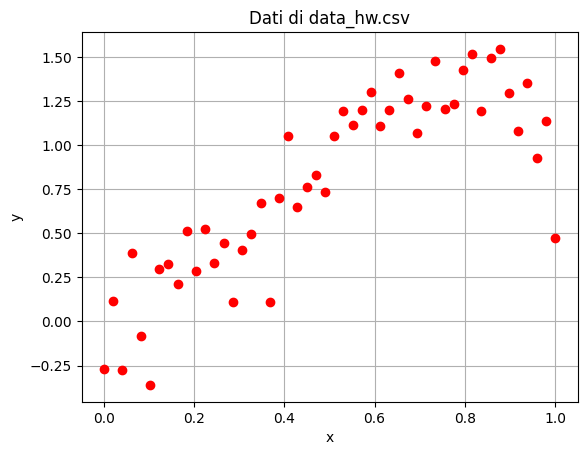

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from ProblemiInversi.solvers import  TSVD, Tikhonov, CGLS

"""
Definsco la funzione f(x, alpha)
in input il vettore alpha dei coefficienti e un vettore x di lunghezza n, 
in output il valore del rispettivo polinomio calcolato su x elemento per elemento
"""
def f(x, alpha):
    d = alpha.shape[0] - 1 # abbiamo detto che la shape di alpha è (d+1, )
    y = np.zeros_like(x) 
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

"""
creo matrice di Vandermonde.
in input ho un vettore x e un intero che indica il grado del polinomio
come output ho la matrice di Vandermonde di grado d associata ad x
"""
def vandermonde(x, d):
    n = x.shape[0]
    X = np.zeros((n, d+1)) # Inizializzo la matrice di Vandermonde con shape (n, d+1)
    for i in range(d+1):  # Costruisco la matrice di Vandermonde
        X[:, i] = x ** i
    return X


data_path = "data_hw.csv" #Set data path
data = pd.read_csv(data_path) # Load data

# Estraggo x e y e li metto in array
x = data["x"].values
y = data["y"].values

# Visualizzazione dei dati
plt.plot(x, y, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dati di data_hw.csv')
plt.grid()
plt.show()

d=3 #d ipotizzato
X = vandermonde(x, d) #inizializzo la matrice di Vandermonde
d_true =4 #d reale  
alpha_true = np.array([0, 0, 4, 0, -3]) #calcolo i coeffici



*  Risolvere il problema ai minimi quadrati tramite metodo delle Equazioni Normali, utilizzando:
   - Il metodo di Cholesky (dopo aver controllato che la matrice ne soddisfa le ipotesi di applicabilità),
   - Soluzione tramite decomposizione SVD,
   - Algoritmo dei Gradienti Coniugati (CGLS).
   
  Confrontare i tre metodi misurando sia il tempo impiegato, che plottando (sullo stesso plot) i polinomi descritti dalla soluzione dei tre metodi, commentando su quale (a occhio) approssima meglio i dati.

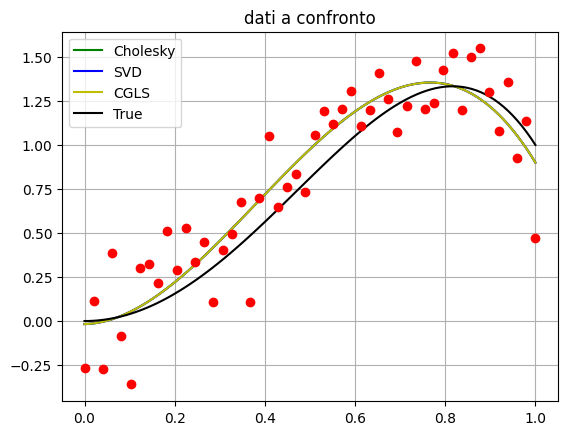

Tempo Cholesky: 0.002969 sec
Tempo SVD: 0.000529 sec
Tempo CGLS: 0.000892 sec


In [9]:
import time
"""
CHOLESKY
condizione necessaria e sufficiente per l’applicabilità del metodo di Cholesky, 
se e solo se la matrice ha rango massimo.
X^T X = L L^T
sistema: I)  L z = X^T y
         II) L^T alpha = z
"""

def chol(X, d):
    if np.linalg.matrix_rank(X) == d+1: #verifico condiZione necessaria e sufficiente

        L = np.linalg.cholesky(X.T @ X)  # Troviamo la matrice L tale che X^T X = L L^T
        
        #risolviamo primo sistema
        Xty = X.T @ y  # Calcoliamo X^T y
        z = np.linalg.solve(L, Xty)  # Risolviamo il sistema L alpha = X^T y
    
        #risolviamo secondo sistema
        alpha_chol = np.linalg.solve(L.T, z)  # Risolviamo il sistema L^T alpha = z
        return alpha_chol

"""
SVD decomposizione in valori singolari
X = U S V^T
dove U e V sono matrici ortogonali, mentre Sigma è una matrice diagonale
i cui elementi sulla diagonale sono i valori singolari di X in ordine decrescente.
"""
def svd(X, y, d):
    # Calcoliamo la SVD di X
    U, s, VT = np.linalg.svd(X)

    # Costruiamo la matrice Sigma esplicitamente utilizzando vett s
    n=X.shape[0]
    Sigma = np.zeros((n, d+1))
    for i in range(d+1):
        Sigma[i, i] = s[i]
    alpha_svd=np.zeros((d+1, )) #inizzializzo alpha
    for i in range(d+1):
        alpha_svd = alpha_svd + (U[:, i].T @ y) / s[i] * VT[i, :]
    return alpha_svd    

"""
CGLS algoritmo gradienti coniugati
efficace quando la matrice A è grande e sparsa
si comporta meglio quando la matrice A è mal condizionata
k(A^T A) = k(A)^2
"""

def cgls(A, y, tol=1e-5, maxit=100):
    # Inizializzazione
    x = np.zeros(A.shape[1])  # x0 = 0
    r = r0 = A.T @ (y - A @ x)     # residuo iniziale
    p = r.copy()              # direzione iniziale
    
    for k in range(maxit):
        # Calcolo valori richiesti
        q = A @ p
        alpha = np.linalg.norm(r)**2 / np.linalg.norm(q)**2

        # Aggiornamento di x e di r
        x = x + alpha * p
        r_new = r - alpha * A.T @ q
        
        # Criterio di arresto
        if np.linalg.norm(r_new) < tol * np.linalg.norm(r0):
            #print(f'Convergenza raggiunta in {k+1} iterazioni.')
            break
        
        # Aggiornamento dei parametri
        beta = np.linalg.norm(r_new)**2 / np.linalg.norm(r)**2
        p = r_new + beta * p
        r = r_new
    
    return x

#richiamo choleshky
start_chol=time.time()
alpha_chol = chol(X,d)
end_chol=time.time()

#richiamo svd
start_svd=time.time()
alpha_svd = svd(X, y, d)
end_svd=time.time()

#richiamo cgls
start_cgls=time.time()
alpha_cgls = cgls(X, y)
end_cgls=time.time()

#Rappresetazioni di tutti i dati
xx=np.linspace(min(x), max(x), 100) #creo un vettore di 100 punti equispaziati tra 0 e 1
yy_chol=f(xx, alpha_chol) 
yy_svd=f(xx, alpha_svd)
yy_cgls=f(xx, alpha_cgls)
yy_true=f(xx, alpha_true)


plt.plot(xx, yy_chol, 'g', label='Cholesky')
plt.plot(xx, yy_svd, 'b', label='SVD')
plt.plot(xx, yy_cgls, 'y', label='CGLS')
plt.plot(xx, yy_true, 'k', label='True')
plt.plot(x, y, 'ro')
plt.title('dati a confronto')
plt.legend()
plt.grid()
plt.show()

# confronto tempi
print(f"Tempo Cholesky: {end_chol - start_chol:.6f} sec")
print(f"Tempo SVD: {end_svd - start_svd:.6f} sec")
print(f"Tempo CGLS: {end_cgls - start_cgls:.6f} sec")


* Ripetere l'esperimento sopra variando il grado `d` del polinomio approssimante in $\{ 0, 1, 2, 3, \dots, 8 \}$. 
Per quale scelta di `d` il polinomio approssimante meglio approssima i dati?


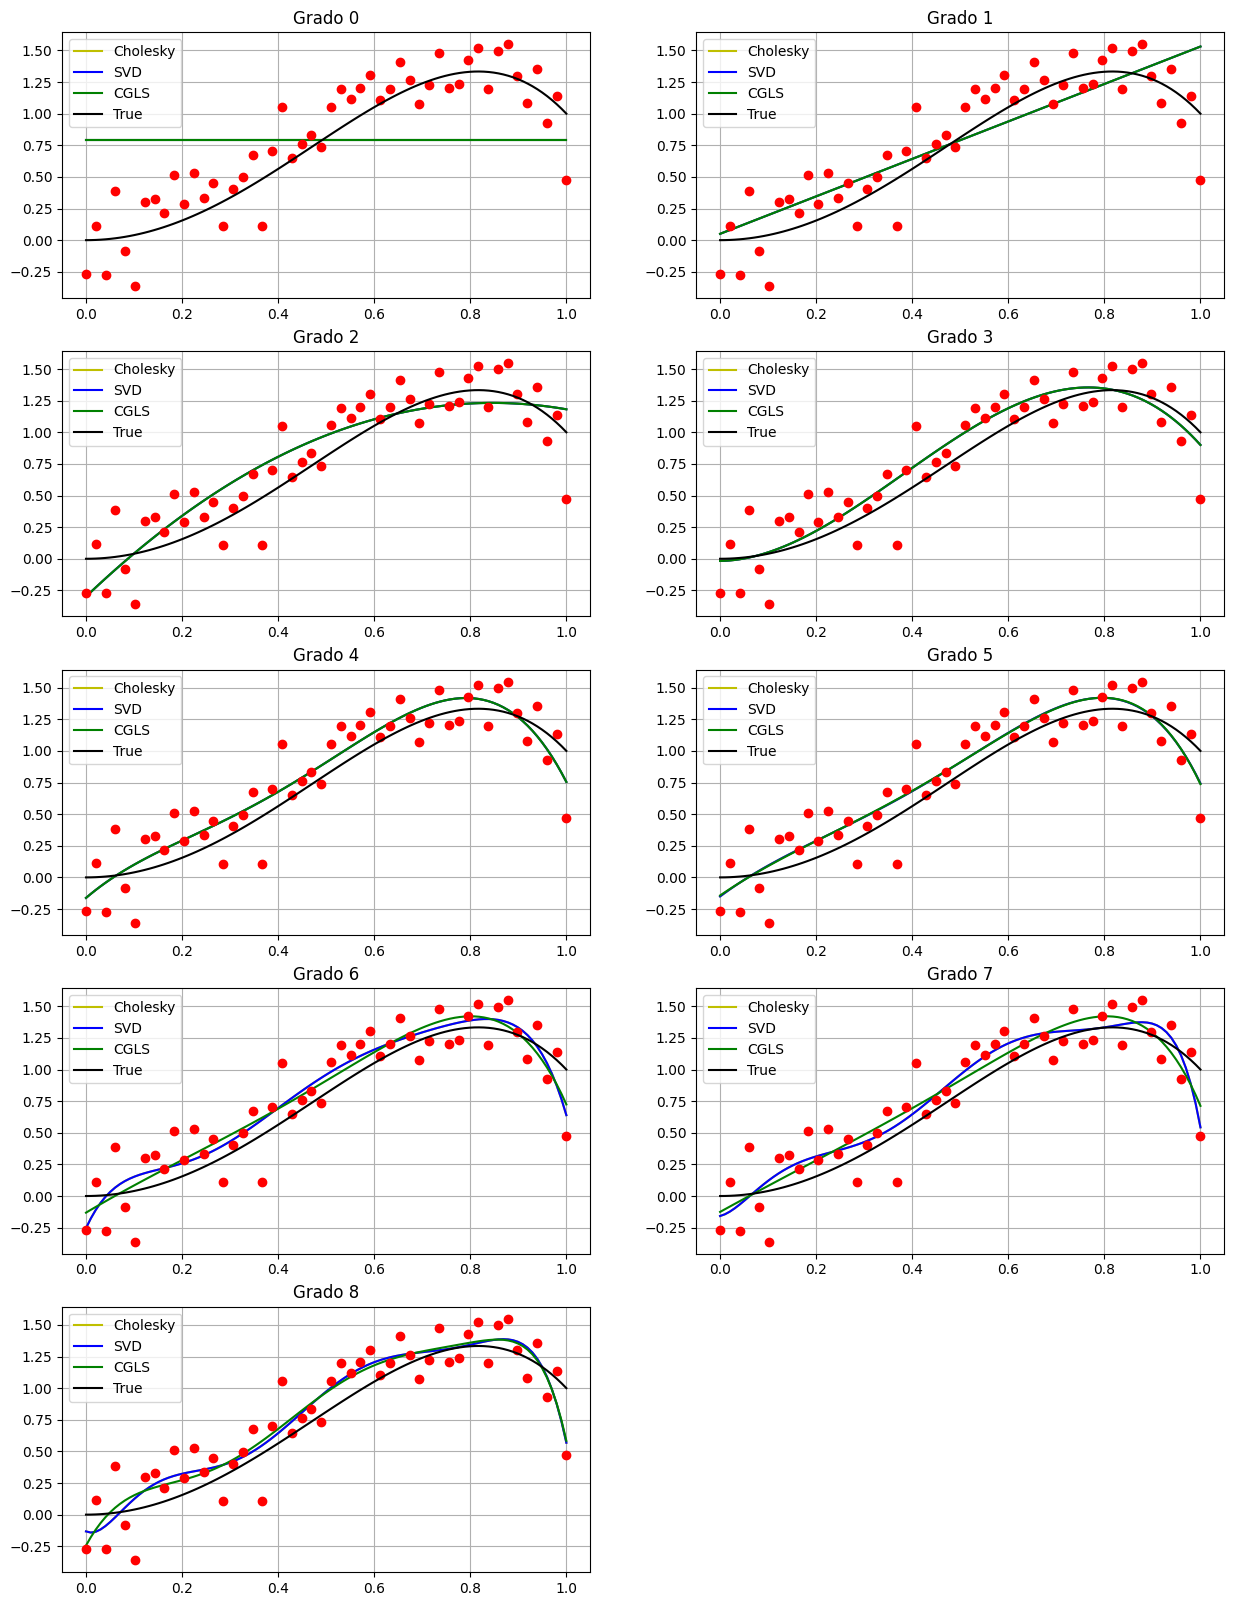

In [10]:
plt.figure(figsize=(15, 20))

alpha_chol= []
alpha_svd= []
alpha_cgls= []
gradi= range(0,9)

for d in gradi:
    X = vandermonde(x, d)
    alpha_chol.append(chol(X, d))
    alpha_svd.append(svd(X, y, d))
    alpha_cgls.append(cgls(X, y))

for d in gradi:
    yy_chol= f(xx, alpha_chol[d])
    yy_svd= f(xx, alpha_svd[d])
    yy_cgls= f(xx, alpha_cgls[d])
    plt.subplot(5, 2, d+1)
    plt.plot(xx, yy_chol,'y', label='Cholesky')
    plt.plot(xx, yy_svd,'b', label='SVD')
    plt.plot(xx, yy_cgls,'g' ,label='CGLS')
    plt.title(f'Grado {d}')
    plt.plot(x, y, 'ro')
    plt.plot(xx, yy_true, 'k', label='True')
    plt.legend()
    plt.grid()
  

* Per `d` = 6, impostare il problema ai minimi quadrati regolarizzato con Tikhonov,
  
  $$
  \min_{\alpha \in \mathbb{R}^{d+1}} \frac{1}{2}|| X \alpha - y ||_2^2 + \frac{\lambda}{2} || Lx ||_2^2,
  $$

  con $L$ matrice identità, e $\lambda > 0$ parametro di regolarizzazione.

* Risolvere il problema ai minimi quadrati regolarizzato con Tikhonov utilizzando:
   - Il metodo di Cholesky (dopo aver controllato che la matrice ne soddisfa le ipotesi di applicabilità),
   - Soluzione tramite decomposizione SVD,
   - Algoritmo dei Gradienti Coniugati (CGLS).
   
  Visualizzare le soluzioni ottenute sul grafico al variare della scelta del parametro $\lambda > 0$. Per quale valore di $\lambda$ il polinomio approssimante meglio approssima i dati?

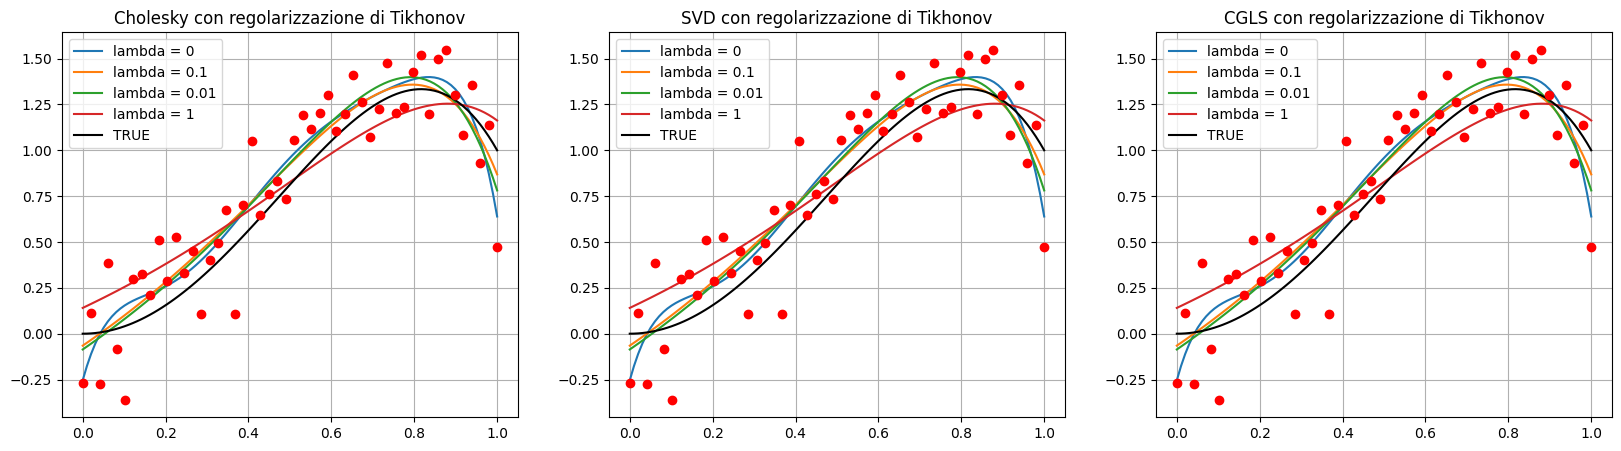

In [11]:
def chol_tikhonov(X, y, lmbda):
    # Troviamo la matrice L tale che X^T X = L L^T
    d = X.shape[1] - 1
    A = X.T @ X + lmbda * np.eye(X.shape[1])
    L = np.linalg.cholesky(A) 
    # Risolviamo il primo sistema
    Xty = X.T @ y # Calcoliamo il termine noto X^T y
    z = np.linalg.solve(L, Xty)    # Troviamo z

    # Risolviamo il secondo sistema
    alpha_chol = np.linalg.solve(L.T, z) # Troviamo alpha
    return alpha_chol

# Funzione per la decomposizione SVD
def svd_tikhonov(X, y, lmbda):
    U, s, Vt = np.linalg.svd(X, full_matrices=False) # Decomposizione SVD
    s_reg = s/(s**2 + lmbda) # Regolarizzazione dei valori singolari
    x = Vt.T @ (s_reg * (U.T @ y))  # Calcolo della soluzione
    return x

"""
CGLS con regolarizzazione di Tikhonov
min_x (1/2) * ||Ax - y||_2^2 + (lam/2) * ||Lx||_2^2
"""
def cgls_tikhonov(A, y, L, lam, tol=1e-6, maxit=100):
    """
    Algoritmo CGLS per risolvere il problema ai minimi quadrati regolarizzati con Tikhonov:
    min_x (1/2) * ||Ax - y||_2^2 + (lam/2) * ||Lx||_2^2
    """
    # Inizializzazione
    x = np.zeros(A.shape[1])
    r = r0 = y - A @ x
    p = A.T @ r - lam * (L.T @ (L @ x)) 
    z = p.copy() # z prende il posto di "p" come direzione

    for k in range(maxit):
        # Calcolo valori richiesti
        q = A @ p
        t = L @ p
        alpha = np.linalg.norm(z)**2 / np.linalg.norm(q)**2
        
        # Calcolo del coefficiente alpha
        alpha = (z.T @ z) / (q.T @ q + lam * (t.T @ t))
        
        # Aggiornamento di x
        x = x + alpha * p
        
        # Aggiornamento del residuo
        r = r - alpha * q
        
        # Verifica del criterio di arresto
        if np.linalg.norm(r) < tol * np.linalg.norm(r0):
            break
        
        # Calcolo della nuova direzione z
        z_new = A.T @ r - lam * (L.T @ (L @ x))
        
        # Calcolo del coefficiente beta
        beta = np.linalg.norm(z_new)**2 / np.linalg.norm(z)**2
        
        # Aggiornamento della direzione p
        p = z_new + beta * p
        z = z_new

    return x


np.random.seed(0)
d=6
X= vandermonde(x, d)
L = np.eye(d+1) # Matrice identità
plt.figure(figsize=(20, 5))

alpha_chol_tik=[]
alpha_svd_tik=[]
alpha_cgls_tik=[]

lmbda_list = [0, 1e-1,1e-2, 1]

for lmbda in lmbda_list:
    alpha_chol_tik.append(chol_tikhonov(X, y, lmbda))
    alpha_svd_tik.append(svd_tikhonov(X, y, lmbda))
    alpha_cgls_tik.append(cgls_tikhonov(X, y,L, lmbda))

legend = []
for i, lmbda in enumerate(lmbda_list):
    yy_chol_tik = f(xx, alpha_chol_tik[i])
    plt.subplot(1,3,1)
    plt.plot(xx, yy_chol_tik)
    legend.append(f"lambda = {lmbda}")
    plt.title('Cholesky con regolarizzazione di Tikhonov')
plt.plot(xx, yy_true, 'k')
legend.append('TRUE')
plt.plot(x, y, 'ro')
plt.legend(legend)
plt.grid()

legend = []
for i, lmbda in enumerate(lmbda_list):
    yy_svd_tik = f(xx, alpha_svd_tik[i])
    plt.subplot(1,3,2)
    plt.plot(xx, yy_svd_tik)
    legend.append(f"lambda = {lmbda}")
    plt.title('SVD con regolarizzazione di Tikhonov')
plt.plot(xx, yy_true, 'k')
legend.append('TRUE')
plt.plot(x, y, 'ro')
plt.legend(legend)
plt.grid()

legend = []
for i, lmbda in enumerate(lmbda_list):
    yy_cgls_tik = f(xx, alpha_cgls_tik[i])
    plt.subplot(1,3,3)
    plt.plot(xx, yy_cgls_tik)
    legend.append(f"lambda = {lmbda}")
    plt.title('CGLS con regolarizzazione di Tikhonov')
plt.plot(xx, yy_true, 'k')
legend.append('TRUE')
plt.plot(x, y, 'ro')
plt.legend(legend)
plt.grid()

plt.show()
    


* Ripetere l'esperimento sopra variando il grado `d` del polinomio approssimante.

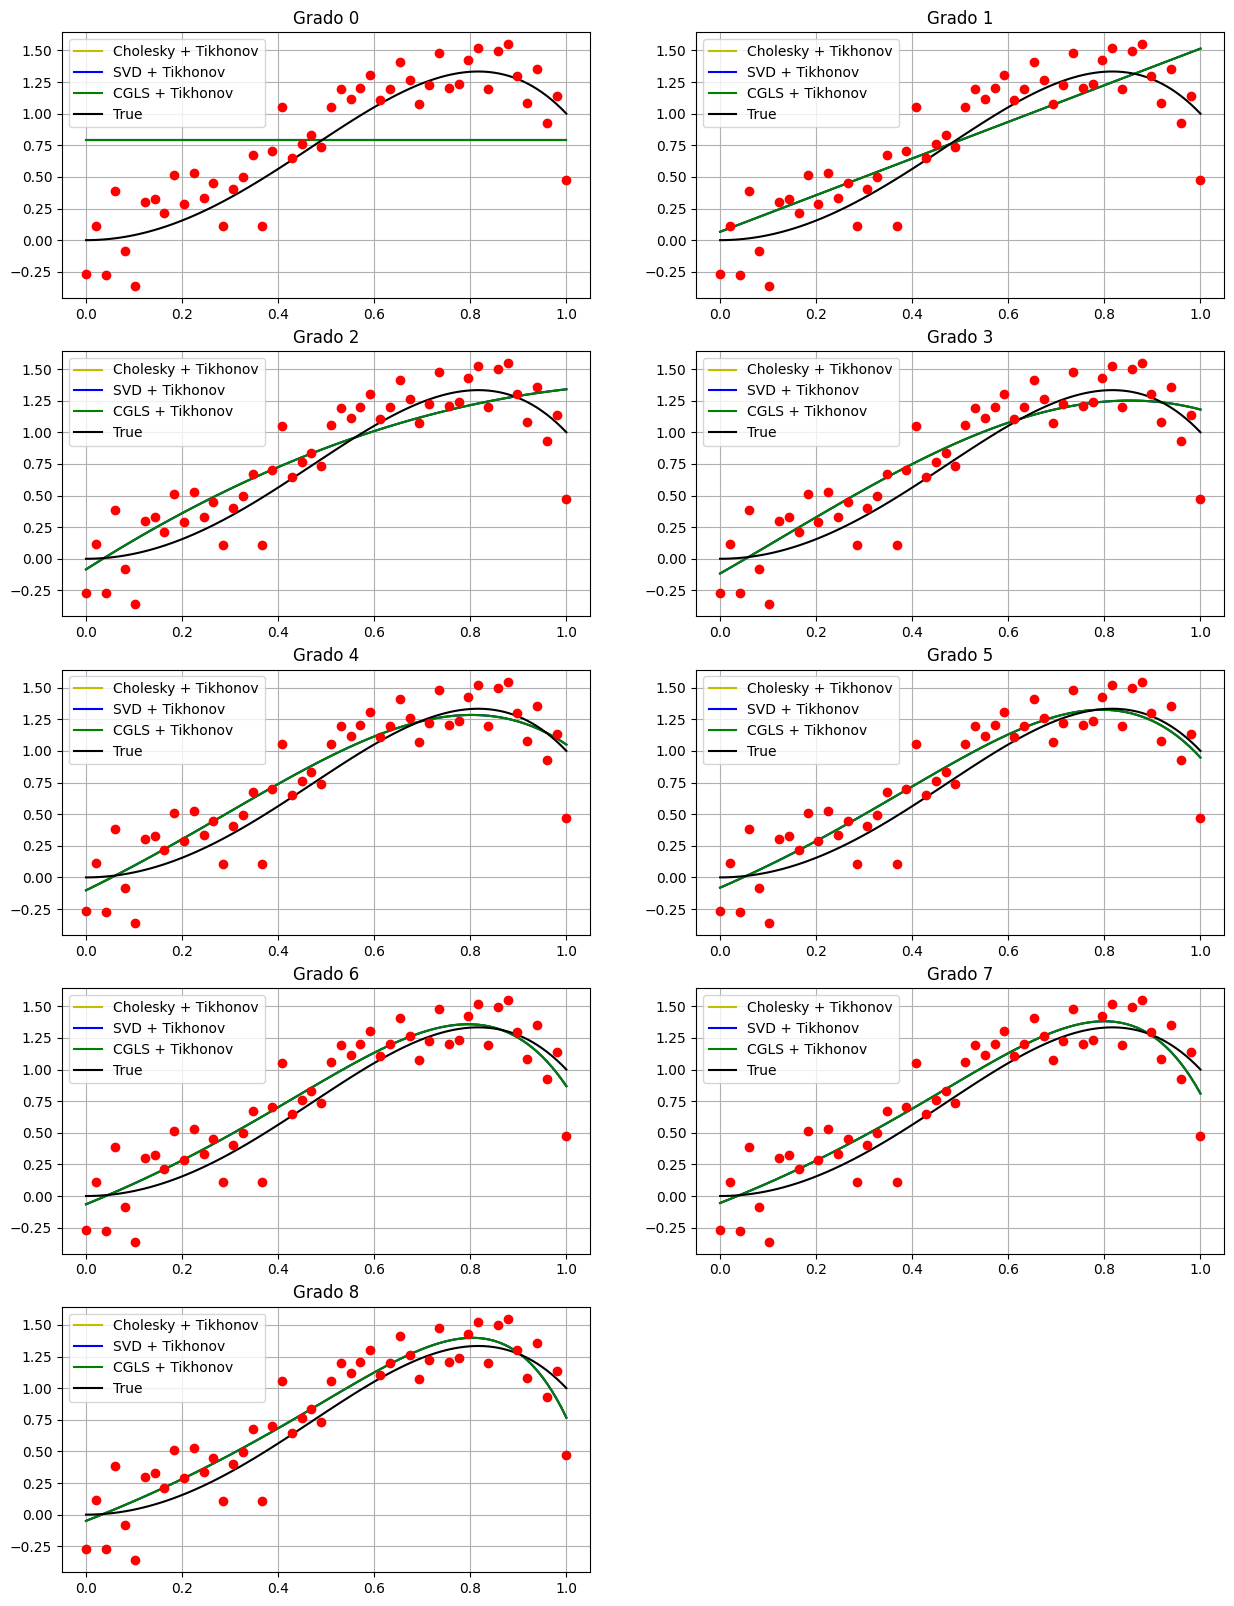

In [12]:
plt.figure(figsize=(15, 20))
np.random.seed(0)

alpha_chol_tik=[]
alpha_svd_tik=[]
alpha_cgls_tik=[]

lmbda=0.1 #parametro di regolarizzazione
gradi= range(0,9)

for d in gradi:
    X = vandermonde(x, d)
    L=np.eye(d+1)
    alpha_chol_tik.append(chol_tikhonov(X, y, lmbda))
    alpha_svd_tik.append(svd_tikhonov(X, y, lmbda))
    alpha_cgls_tik.append(cgls_tikhonov(X, y, L, lmbda))

for d in gradi:
    yy_chol_tik= f(xx, alpha_chol_tik[d])
    yy_svd_tik= f(xx, alpha_svd_tik[d]) 
    yy_cgls_tik= f(xx, alpha_cgls_tik[d])
    plt.subplot(5, 2, d+1)
    plt.plot(xx, yy_chol_tik,'y', label='Cholesky + Tikhonov')
    plt.plot(xx, yy_svd_tik,'b', label='SVD + Tikhonov')
    plt.plot(xx, yy_cgls_tik,'g' ,label='CGLS + Tikhonov')
    plt.title(f'Grado {d}')
    plt.plot(xx, yy_true, 'k', label='True')
    plt.plot(x, y, 'ro')
    plt.legend()
    plt.grid()


Ripetere l'esperimento sopra utilizzando come matrice di Tikhonov $L$ la matrice:

  $$
  L = \begin{bmatrix} 
        1 & -1 & 0 & 0 & \dots & 0 \\
        0 & 1 & -1 & 0 & \dots & 0 \\ 
        0 & 0 & 1 & -1 & \dots & 0 \\ 
        0 & 0 & 0 & 1 & \dots & 0 \\ 
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
        0 & 0 & 0 & 0 & \dots & -1 \\ 
        0 & 0 & 0 & 0 & \dots & 1 \\ 
      \end{bmatrix},
  $$

  ovvero la matrice (di dimensione $n \times n$, dove $n$ è uguale al numero di elementi di $x$), che ha tutti valori $1$ sulla diagonale, e valori $-1$ sulla sovra-diagonale. Come cambiano i risultati precedenti per questa scelta di $L$?

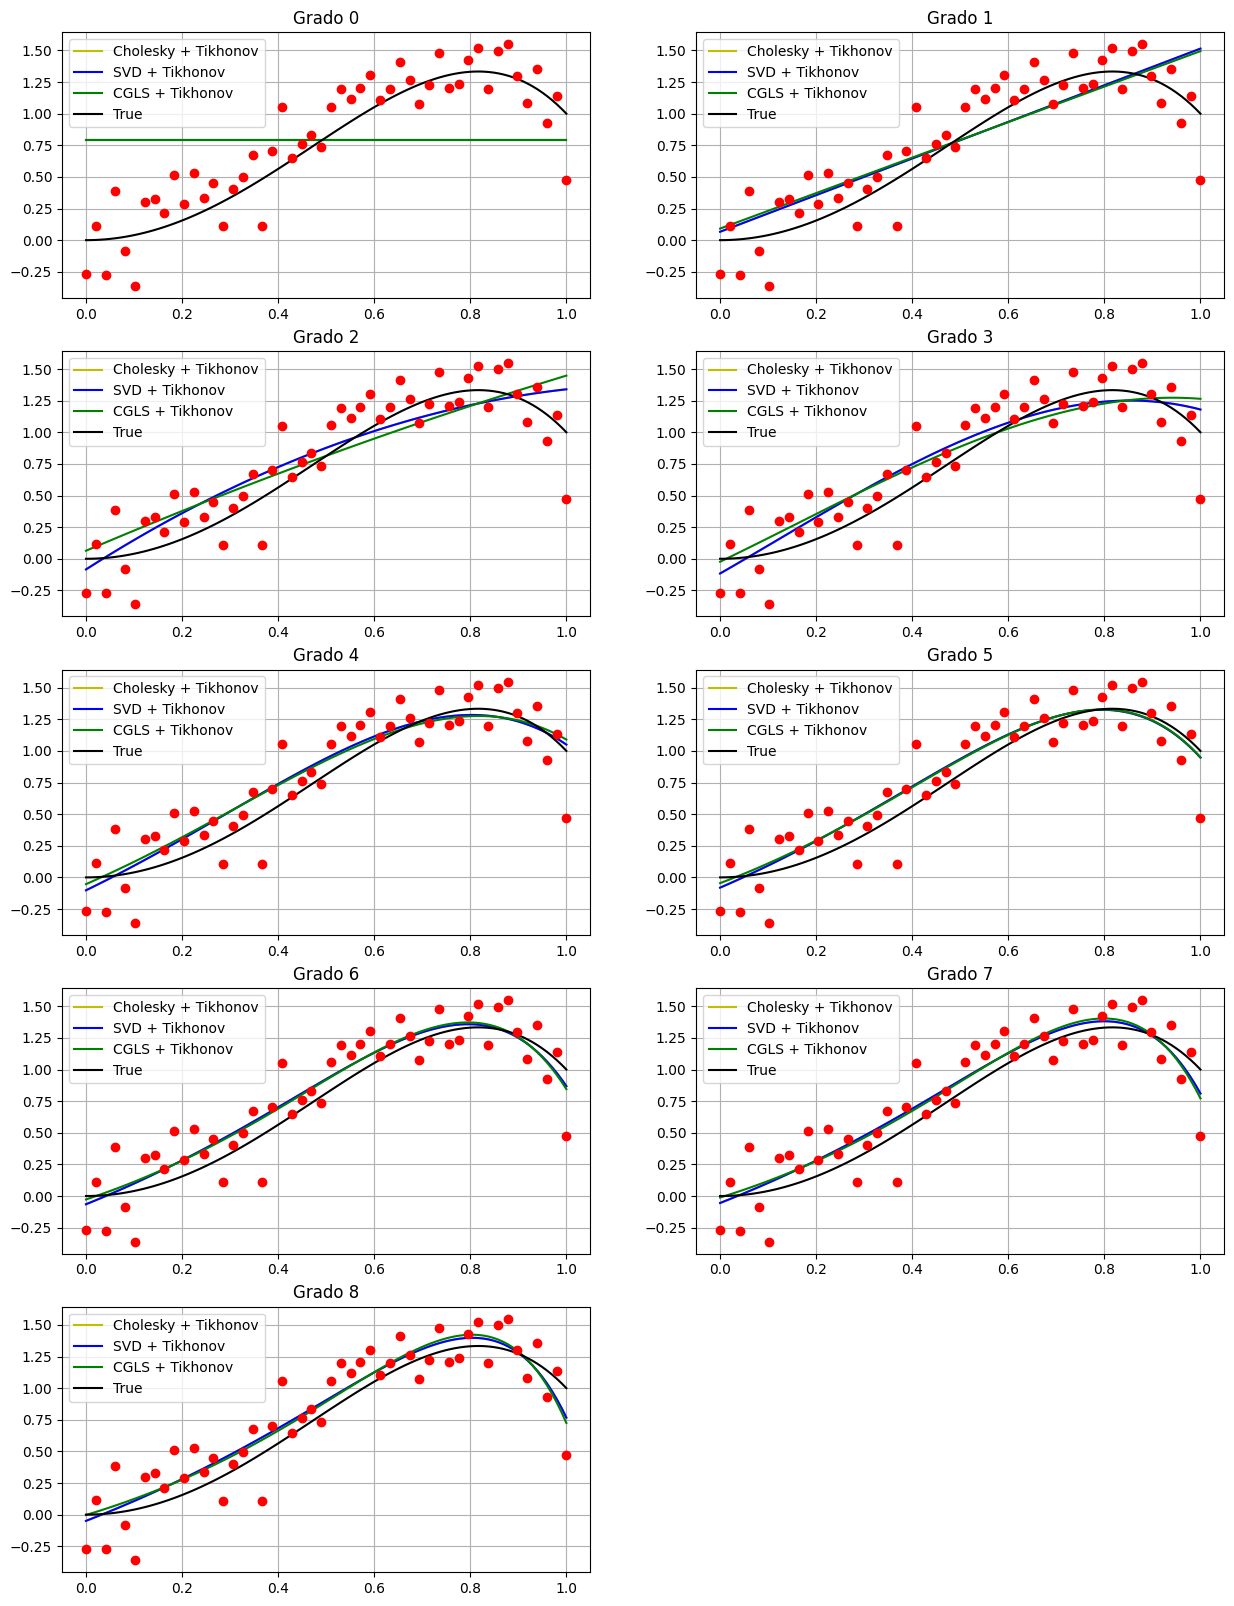

In [13]:
def build_tikhonov_matrix(n):
    L = np.zeros((n, n))
    for i in range(n - 1):
        L[i, i] = 1
        L[i, i + 1] = -1
    L[n - 1, n - 1] = 1
    return L

plt.figure(figsize=(15, 20))
np.random.seed(0)

alpha_chol_tik=[]
alpha_svd_tik=[]
alpha_cgls_tik=[]

lmbda=0.1 #parametro di regolarizzazione
gradi= range(0,9)

for d in gradi:
    X = vandermonde(x, d)
    L=build_tikhonov_matrix(d+1)
    alpha_chol_tik.append(chol_tikhonov(X, y, lmbda))
    alpha_svd_tik.append(svd_tikhonov(X, y, lmbda))
    alpha_cgls_tik.append(cgls_tikhonov(X, y, L, lmbda))

for d in gradi:
    yy_chol_tik= f(xx, alpha_chol_tik[d])
    yy_svd_tik= f(xx, alpha_svd_tik[d]) 
    yy_cgls_tik= f(xx, alpha_cgls_tik[d])
    plt.subplot(5, 2, d+1)
    plt.plot(xx, yy_chol_tik,'y', label='Cholesky + Tikhonov')
    plt.plot(xx, yy_svd_tik,'b', label='SVD + Tikhonov')
    plt.plot(xx, yy_cgls_tik,'g' ,label='CGLS + Tikhonov')
    plt.title(f'Grado {d}')
    plt.plot(xx, yy_true, 'k', label='True')
    plt.plot(x, y, 'ro')
    plt.legend()
    plt.grid()



* Sapendo ora che `d_true` = 4 e `alpha_true = np.array([0, 0, 4, 0, -3])`, misurare (per **alcuni** degli esperimenti fatti sopra (i più promettenti)) l'errore relativo tra il valore di `alpha` calcolato e `alpha_true`, e confrontare visivamente su grafico i polinomi approssimanti rispetto al polinomio reale (senza rumore) ottenuto tramite `alpha_true`. Commentare i risultati ottenuti.

```{warning}
L'errore relativo tra `alpha` e `alpha_true` può ovviamente essere calcolato **solo** nel caso in cui il grado `d` del polinomio approssimante sia uguale a 4. In tutti gli altri casi, limitarsi ad un confronto visivo sul grafico.
```

In [14]:

def errore_rel(alpha, alpha_true):
    return np.linalg.norm(alpha - alpha_true) / np.linalg.norm(alpha_true)


X= vandermonde(x, d_true)
L=np.eye(d_true+1)


alpha_chol = chol(X, d_true)
alpha_svd = svd(X, y, d_true)
alpha_cgls = cgls(X, y)

# Calcolo dell'errore relativo
errore_chol = errore_rel(alpha_chol, alpha_true)
errore_svd = errore_rel(alpha_svd, alpha_true)
errore_cgls = errore_rel(alpha_cgls, alpha_true)

print(f"Errore relativo Cholesky: {errore_chol:.6f}")
print(f"Errore relativo SVD: {errore_svd:.6f}")
print(f"Errore relativo CGLS: {errore_cgls:.6f}")

lmbda_list = [0, 1e-1,1e-2, 1]

alpha_chol_tik=[]
alpha_svd_tik=[]
alpha_cgls_tik=[]

for lmbda in lmbda_list:
    alpha_chol_tik.append(chol_tikhonov(X, y, lmbda))
    alpha_svd_tik.append(svd_tikhonov(X, y, lmbda))
    alpha_cgls_tik.append(cgls_tikhonov(X, y, L, lmbda))

for i,lmbda in  enumerate(lmbda_list):
    errore_chol_tik = errore_rel(alpha_chol_tik[i], alpha_true)
    errore_svd_tik = errore_rel(alpha_svd_tik[i], alpha_true)
    errore_cgls_tik = errore_rel(alpha_cgls_tik[i], alpha_true)
    print("\nlambda = ", lmbda)
    print(f"Errore relativo Cholesky con Tikhonov: {errore_chol_tik:.6f}")
    print(f"Errore relativo SVD con Tikhonov: {errore_svd_tik:.6f}")
    print(f"Errore relativo CGLS con Tikhonov: {errore_cgls_tik:.6f}")



Errore relativo Cholesky: 4.533171
Errore relativo SVD: 4.533171
Errore relativo CGLS: 4.533171

lambda =  0
Errore relativo Cholesky con Tikhonov: 4.533171
Errore relativo SVD con Tikhonov: 4.533171
Errore relativo CGLS con Tikhonov: 4.533171

lambda =  0.1
Errore relativo Cholesky con Tikhonov: 0.785753
Errore relativo SVD con Tikhonov: 0.785753
Errore relativo CGLS con Tikhonov: 0.785753

lambda =  0.01
Errore relativo Cholesky con Tikhonov: 0.493055
Errore relativo SVD con Tikhonov: 0.493055
Errore relativo CGLS con Tikhonov: 0.493055

lambda =  1
Errore relativo Cholesky con Tikhonov: 0.905260
Errore relativo SVD con Tikhonov: 0.905260
Errore relativo CGLS con Tikhonov: 0.905260
